# More simulation: Combining step protocols with sine waves or ramps

In the next parts of the tutorial, we'll look at some more voltage protocols that have been used in fitting, and discuss the methods most appropriate to each one.

## Adding ramps to the step protocol

Previous examples used a [myokit.Protocol](https://myokit.readthedocs.io/api_simulations/Protocol.html) to encode a voltage protocol consisting of a sequence of fixed-voltage steps.
In the examples below we'll show how to dynamically update a model's equations to allow more complex shapes such as ramps and sine waves.

In particular, we'll try to copy the following protocol:

CHON CHON CHON

odict_keys(['time', 'voltage'])


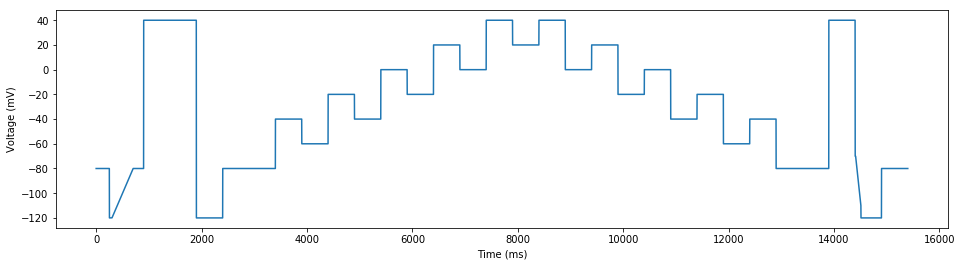

In [2]:
import matplotlib.pyplot as plt
import myokit
import numpy as np

# Load a CSV file
d1 = myokit.DataLog.load_csv('resources/protocol-staircaseramp.csv')

# Convert Python lists to NumPy arrays
d1 = d1.npview()

# Convert time to ms
d1['time'] *= 1000

# Get time just after protocol is finished
tmax = d1['time'][-1] + 0.1

# Show the contents
print(d1.keys())

# Create a plot
plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.plot(d1.time(), d1['voltage'])
plt.show()

In previous examples, we used a ramp-free version of the protocol:

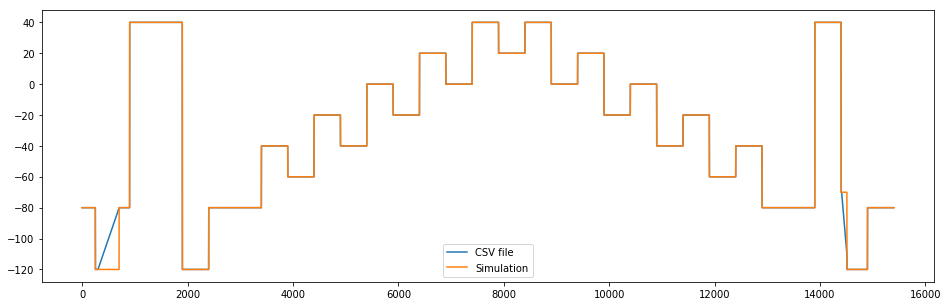

In [3]:
m = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
p = myokit.load_protocol('resources/simplified-staircase.mmt')
s = myokit.Simulation(m, p)

d2 = s.run(tmax, log_times=d1.time())

plt.figure(figsize=(16, 5))
plt.plot(d1.time(), d1['voltage'], label='CSV file')
plt.plot(d2.time(), d2['membrane.V'], label='Simulation')
plt.legend()
plt.show()

To add in the ramps, we inspect the CSV file a bit closer and define equations for both.

### Ramp 1

$V_1(t=300) = -120$

$V_1(t=700) = -80$

$V_1 = -120 + (t - 300) * 40 / 400 = -150 + t / 10$


### Ramp 2

$V_1(t=14410) = -70$

$V_1(t=14510) = -110$

$V_2 = -70 + (t - 14410) * -40 / 100 = 5694 - 0.4 t$

We can check graphically that these equations create the lines we want them to:

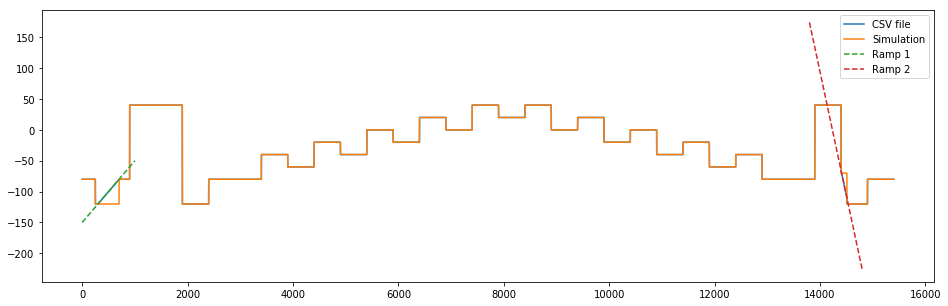

In [4]:
plt.figure(figsize=(16, 5))
plt.plot(d1.time(), d1['voltage'], label='CSV file')
plt.plot(d2.time(), d2['membrane.V'], label='Simulation')

t1 = np.linspace(0, 1000, 1000)
v1 = -150 + 0.1 * t1

t2 = np.linspace(13800, 14800, 1000)
v2 = 5694 - 0.4 * t2

plt.plot(t1, v1, '--', label='Ramp 1')
plt.plot(t2, v2, '--', label='Ramp 2')

plt.legend()
plt.show()

Now we'll add these ramps into the model, by programmatically modifying the `membrane` component:

In [5]:
print(m.get('membrane').code())

[membrane]
V = 0 [mV] bind pace label membrane_potential




We'll replace this by something of the form:

\begin{align}
vp  &= \text{step protocol} \\
v1 &= -150 + 0.1 * t \\
v2 &= 5694 - 0.4 * t \\
V  &= \begin{cases}
    v1 & \mbox{ if } 300 \leq t < 700 \\
    v2 & \mbox{ if } 14410 \leq t < 14510 \\
    vp  & \mbox{ otherwise} \\
\end{cases}
\end{align}

In [6]:
# Load the model
m = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Get the membrane component
c = m.get('membrane')

# Get the voltage variable, and remove its binding to `pace`
v = c.get('V')
v.set_binding(None)

# Add a v1 variable
v1 = c.add_variable('v1')
v1.set_rhs('-150 + 0.1 * engine.time')

# Add a v2 variable
v2 = c.add_variable('v2')
v2.set_rhs('5694 - 0.4 * engine.time')

# Add a p variable
vp = c.add_variable('vp')
vp.set_rhs(0)
vp.set_binding('pace')

# Set a new right-hand side equation for V
v.set_rhs("""
    piecewise(
        (engine.time >= 300 and engine.time < 700), v1, 
        (engine.time >=14410 and engine.time < 14510), v2, 
        vp)
""")

In [7]:
print(c.code())

[membrane]
V = piecewise(engine.time >= 300 and engine.time < 700, v1, engine.time >= 14410 and engine.time < 14510, v2, vp)
    label membrane_potential
v1 = -150 + 0.1 * engine.time
v2 = 5694 - 0.4 * engine.time
vp = 0 bind pace




We now run a simulation with the updated model and compare:

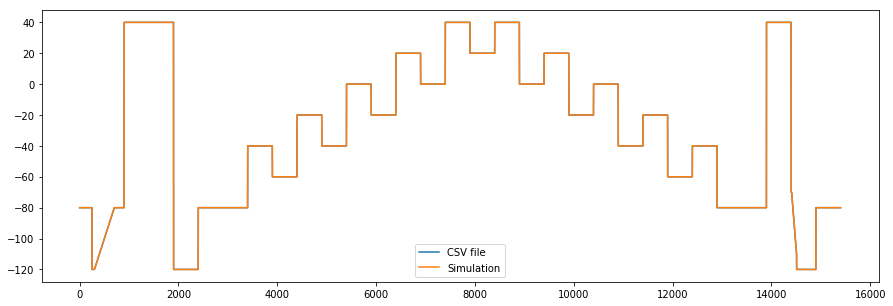

In [8]:
s = myokit.Simulation(m, p)

d2 = s.run(tmax+10, log_times=d1.time())

plt.figure(figsize=(15, 5))
plt.plot(d1.time(), d1['voltage'], label='CSV file')
plt.plot(d2.time(), d2['membrane.V'], label='Simulation')
plt.legend()
plt.show()

Just to be sure, we inspect the difference:

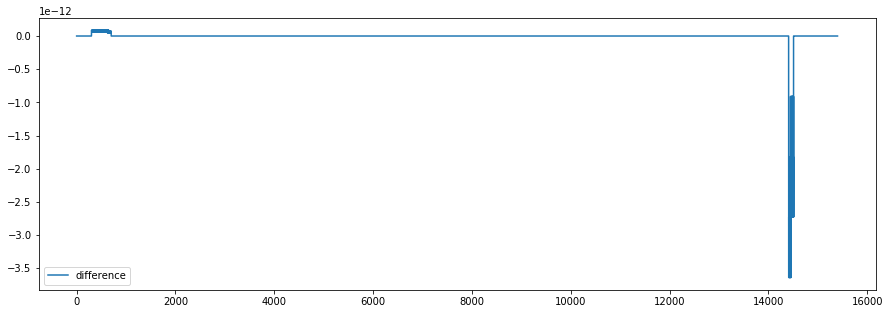

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(d1.time(), d1['voltage'] - d2['membrane.V'], label='difference')
plt.legend()
plt.show()

So, we have matched the protocol in the CSV file very closely!

## Combining steps and sine waves

Just like in the example above, we can use a combination of a step protocol and dynamically added equations to implement the sine wave protocol use in ["Sinusoidal voltage protocols for rapid characterisation of ion channel kinetics"](https://physoc.onlinelibrary.wiley.com/doi/full/10.1113/JP275733). 
This is the approach taken in the [code for "Four ways of fitting an ion channel model"](https://github.com/CardiacModelling/FourWaysOfFitting).

Once again, we start from a step protocol:

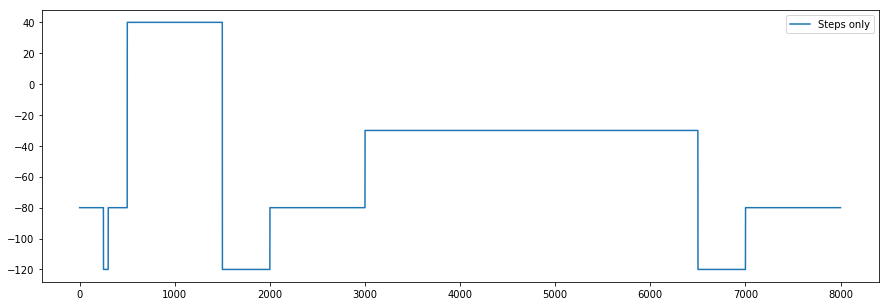

In [10]:
import matplotlib.pyplot as plt
import myokit
import numpy as np

m = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
p = myokit.load_protocol('resources/sine-wave-steps.mmt')
s = myokit.Simulation(m, p)

tmax = 8000
times = np.linspace(0, tmax, tmax*10)
d1 = s.run(tmax, log_times=times)

plt.figure(figsize=(15, 5))
plt.plot(d1.time(), d1['membrane.V'], label='Steps only')
plt.legend()
plt.show()

Next, we dynamically add in the sine waves (using the definitions given in the original paper as our guide):

In [11]:
# Load the model
m = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Get the membrane component
c = m.get('membrane')

# Get the voltage variable, and remove its binding to `pace`
v = c.get('V')
v.set_binding(None)

# Add a p variable
vp = c.add_variable('vp')
vp.set_rhs(0)
vp.set_binding('pace')

# Update V's RHS
m.get('membrane.V').set_rhs(
    'if(engine.time >= 3000.1 and engine.time < 6500.1,'
    + ' - 30'
    + ' + 54 * sin(0.007 * (engine.time - 2500.1))'
    + ' + 26 * sin(0.037 * (engine.time - 2500.1))'
    + ' + 10 * sin(0.190 * (engine.time - 2500.1))'
    + ', vp)')


We can now run simulations with the updated model:

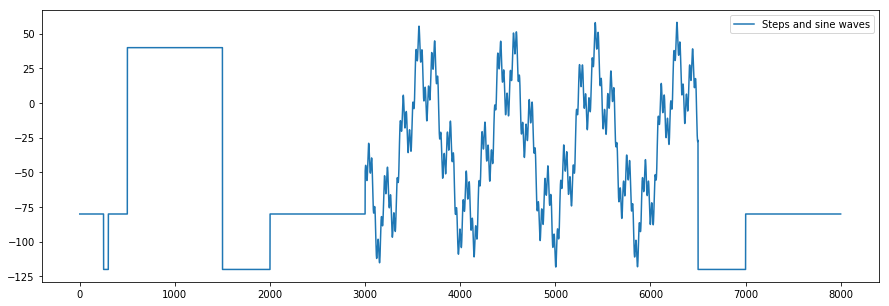

In [12]:
s = myokit.Simulation(m, p)

d2 = s.run(tmax, log_times=times)

plt.figure(figsize=(15, 5))
plt.plot(d2.time(), d2['membrane.V'], label='Steps and sine waves')
plt.legend()
plt.show()